# Initalizing the problem

In [54]:
import numpy as np
from scipy.signal import butter, filtfilt
import python_anesthesia_simulator as pas
import matplotlib.pyplot as plt
import random
import pickle
random.seed(15)
np.random.seed(15)

# load patient data
with open('patients_data_1100.pkl', 'rb') as f:
    patient_dic = pickle.load(f)

# define output function
def output(x, PD_par):
  c50p, c50r, gamma, _, _, _ = PD_par
  Up, Ur = x[3]/c50p, x[7]/c50r
  U = np.abs(Up + Ur)
  y = 97.4 * (1 - np.divide(U**gamma, 1 + U**gamma))
  return y

# define measurement noise
class measurement_noise:
    def __init__(self, num_samples, std_dev=3, cutoff=0.03, fs=1.0, order=2):
        self.num_samples = num_samples
        self.std_dev = std_dev
        self.cutoff = cutoff
        self.fs = fs
        self.order = order

    def generate_white_noise(self):
        return np.random.normal(0, self.std_dev, self.num_samples)

    def butter_lowpass_filter(self):
        nyquist = 0.5 * self.fs
        normal_cutoff = self.cutoff / nyquist
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply_filter(self, data):
        b, a = self.butter_lowpass_filter()
        return filtfilt(b, a, data)

    def generate(self):
        white_noise = self.generate_white_noise()
        return self.apply_filter(white_noise)

# Controller A

## defining the controller

In [55]:
class PID_A():
    def __init__(self, Kp, Ti, Td, gamma_p, ts):
        self.Kp = Kp
        self.Ti = Ti
        self.Td = Td
        self.gamma_p = gamma_p
        self.ts = ts
        self.N = 5

        self.last_error = 97.4 - 50 # initial error
        self.integral_part = 0
        self.derivative_part = 0
        self.ratio = 2
        self.Kp_history = []

    def one_step(self, BIS, y_ref):
        self.error = BIS - y_ref
        self.integral_part += self.ts / self.Ti * self.error
        self.derivative_part = (self.derivative_part * self.Td / self.N + self.Td * (self.error - self.last_error)) / (self.ts + self.Td / self.N)
        
        self.control_input = self.Kp * (self.error + self.integral_part + self.derivative_part)
        up = self.control_input # propofol infusion
        ur = self.control_input * self.ratio # remifentanil infusion

        # adapt Kp
        self.Kp += np.tanh(self.error) * self.gamma_p * self.error
        self.Kp = np.clip(self.Kp, 1e-4, 1)
        self.Kp_history.append(self.Kp)

        # apply anti-windup
        if ((up > 6.67 ) or (ur > 16.67)) or (((up > 6.67 ) or (ur > 16.67)) and (self.control_input * self.error >= 0)):
            up, ur = min(6.67, up), min(16.67, ur)
            self.integral_part -= self.ts / self.Ti * self.error # freeze the integral at its past value

        if ((up < 0 ) or (ur < 0)) or (((up < 0 ) or (ur < 0)) and (self.control_input * self.error >= 0)):
            up, ur = max(0, up), max(0, ur)
            self.integral_part -= self.ts / self.Ti * self.error # freeze the integral at its past value
        
        control_signal = [np.clip(up, 0, 6.67), np.clip(ur, 0, 16.67)] # saturation blocks

        self.last_error = self.error

        return control_signal

## defining the simulation function

In [56]:
random.seed(15)
np.random.seed(15)

def pid_A_sim(Kp_i, Ti_i, Td_i, gamma_p_i, Kp_m, Ti_m, Td_m, t_sim, ts, patient_index, model_type='uncertain', noise=False):
    Ad_nom, Bd_nom, Ad_pert, Bd_pert, _, PD_nom, PD_real, _ = patient_dic[f'patient_{patient_index+1}']
    
    # two PID controllers for induction and maintenance
    pid_ind = PID_A(Kp=Kp_i, Ti=Ti_i, Td=Td_i, gamma_p = gamma_p_i, ts=ts)
    pid_mnt = PID_A(Kp=Kp_m, Ti=Ti_m, Td=Td_m, gamma_p = 0, ts=ts)

    # run the pid
    u_pid = np.zeros((2, t_sim))
    x_real = np.zeros(8)
    x_nom = np.zeros(8)
    y_meas = np.ones(t_sim)*97.4
    y_clean = np.zeros(t_sim)
    # y_clean is the actual BIS of the patient that we don't have access to in reality,
    # not the measured one that is affected by noise. The measured BIS is used as a
    # feedback to the controller. y_clean is used to study the actual effect of the
    # control action on the BIS of the patient in the presence of noisy measurements.
    Kp_hist = np.ones(600)

    if noise == True:
        noise = measurement_noise(t_sim).generate()
    else:
        noise = np.zeros(t_sim)

    for k in range(t_sim):
        if model_type == 'nominal':
            y_clean[k] = output(x_nom, PD_nom) + pas.disturbances.compute_disturbances(k, 'step', 600, 1200)[0]
        elif model_type == 'uncertain':
            y_clean[k] = output(x_real, PD_real) + pas.disturbances.compute_disturbances(k, 'step', 600, 1200)[0]
        y_meas[k] = np.clip(y_clean[k] + noise[k], 0, 100)
        
        if np.mod(k, ts) == 0:
            if k >= 600:
                delta = y_meas[k] - 50
                if delta > 0:
                    y_ref = np.clip(100 - y_meas[k], 40, 50)
                else:
                    y_ref = 50
                u_pid[:, k] = pid_mnt.one_step(y_meas[k], y_ref)
            else:
                u_pid[:, k] = pid_ind.one_step(y_meas[k], 50)
                Kp_hist[k] = pid_ind.Kp_history[-1]
        else:
            u_pid[:, k] = u_pid[:, k-1]
            if k < 600:
                Kp_hist[k] = Kp_hist[k-1]
        x_real = Ad_pert @ x_real + Bd_pert @ u_pid[:, k]
        x_nom = Ad_nom @ x_nom + Bd_nom @ u_pid[:, k]

    return y_clean, u_pid, Kp_hist

## running the controller

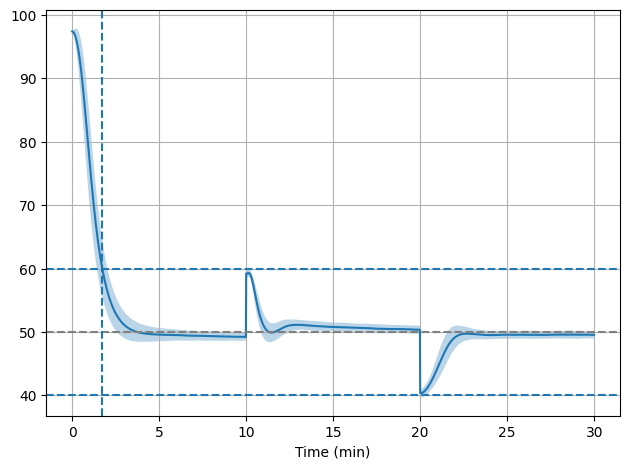

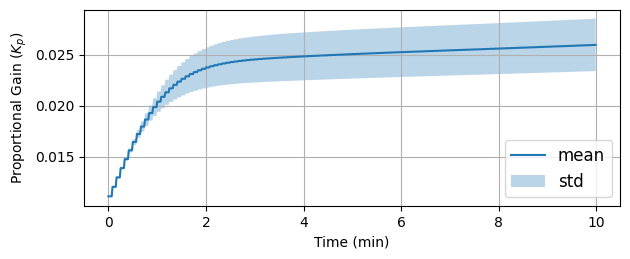

In [57]:
t_sim, ts = 1800, 5
variables = [pid_A_sim(0.0102, 465, 26, 1.972e-5, 0.0602, 585, 10, t_sim, ts, k, model_type='uncertain', noise=True) for k in range(100, 1100)]
nb_patients = 1100 - 100
bis = np.zeros((nb_patients, t_sim))
drug = np.zeros((nb_patients, 2, t_sim))
Kp_evol = np.zeros((nb_patients, 600))

for i in range(nb_patients):
    bis[i] = variables[i][0]
    drug[i] = variables[i][1]
    Kp_evol[i] = variables[i][2]
sleep = np.argmax(bis < 60, axis=1)
bis_A = bis
drug_A = drug

# plotting the BIS
mean = np.mean(bis, axis=0)
std = np.std(bis, axis=0)
plt.figure()
time_in_minutes = np.arange(bis.shape[1]) / 60
plt.plot(time_in_minutes, mean)
plt.fill_between(time_in_minutes, mean - std, mean + std, alpha=0.3)
plt.axhline(y=40, linestyle = '--')
plt.axhline(y=50, linestyle = '--', color='grey')
plt.axhline(y=60, linestyle = '--')
plt.axvline(x=sleep.mean()/60, linestyle='--')
plt.xlabel('Time (min)')
plt.grid(True)
plt.tight_layout()

# plotting kp evolution in the induction phase
mean_kp = np.mean(Kp_evol, axis=0)
std_kp = np.std(Kp_evol, axis=0)
plt.figure()
plt.subplot(2, 1, 1)
time_in_minutes_kp = np.arange(Kp_evol.shape[1]) / 60
plt.plot(time_in_minutes_kp, mean_kp, label='mean')
plt.fill_between(time_in_minutes_kp, mean_kp - std_kp, mean_kp + std_kp, alpha=0.3, label='std')
plt.xlabel('Time (min)')
plt.ylabel('Proportional Gain ($K_p$)')
plt.legend(fontsize='large', loc='lower right')
plt.grid(True)
plt.tight_layout()
# plt.savefig('kp_evol.pdf', bbox_inches='tight')

## induction phase metrics

In [58]:
# time to sleep
tts = (sleep)/60
tts_mean = tts.mean()
tts_std = tts.std()

# low bis time
index = np.zeros((nb_patients, 600))
for i in range(nb_patients):
    for j in range(600):
        if (bis[i, j] < 40):
            index[i, j] = 1
lbt = index.sum(axis=1)
lbt_mean = lbt.mean()
lbt_std = lbt.std()

# lower bis value / bis nadir
BIS_nadir = bis[:, :600].min(axis=1)
BIS_nadir_mean = BIS_nadir.mean()
BIS_nadir_std = BIS_nadir.std()

# settling time 20
st20 = np.zeros(1000)
for i in range(1000):
    for j in range(600-30):
        window = bis[i][j:j+30]
        if np.all((window >= 40)) and np.all((window <= 60)):
            st20[i] = j
            break
st20 = st20/60
st20_mean = st20.mean()
st20_std = st20.std()

# settling time 10
st10 = np.zeros(1000)
for i in range(1000):
    for j in range(600-30):
        window = bis[i][j:j+30]
        if np.all((window >= 45)) and np.all((window <= 55)):
            st10[i] = j
            break
st10 = st10/60
st10_mean = st10.mean()
st10_std = st10.std()

# propofol volume
weight = []
weight += [patient_dic[f'patient_{k}'][4][2] for k in range(100, 1100)]
weight = np.array(weight)[:, np.newaxis]
propo = np.divide(drug[:, 0, :600], weight).sum(axis=1)
propo_mean = propo.mean()
propo_std = propo.std()

# remifentanil volume
remi = np.divide(drug[:, 1, :600], weight).sum(axis=1)
remi_mean = remi.mean()
remi_std = remi.std()

In [59]:
print(f'''
      Time to sleep: {tts_mean:.2f} ± {tts_std:.2f} (in minutes)
      Low BIS time: {lbt_mean:.2f} ± {lbt_std:.2f} (in minutes)
      BIS Nadir: {BIS_nadir_mean:.2f} ± {BIS_nadir_std:.2f} (%)
      Settling Time 20: {st20_mean:.2f} ± {st20_std:.2f} (in minutes)
      Settling Time 10: {st10_mean:.2f} ± {st10_std:.2f} (in minutes)
      Propofol volume: {propo_mean:.2f} ± {propo_std:.2f} (in mg/kg)
      Remifentanil volume: {remi_mean:.2f} ± {remi_std:.2f} (in μg/kg)
''')


      Time to sleep: 1.73 ± 0.29 (in minutes)
      Low BIS time: 0.18 ± 4.08 (in minutes)
      BIS Nadir: 48.69 ± 1.09 (%)
      Settling Time 20: 1.73 ± 0.29 (in minutes)
      Settling Time 10: 2.20 ± 0.41 (in minutes)
      Propofol volume: 1.90 ± 0.70 (in mg/kg)
      Remifentanil volume: 3.80 ± 1.39 (in μg/kg)



## maintenance phase metrics

In [60]:
# Integral Absolute Error
IAE = np.sum(np.abs(bis[:, 600:] - 50), axis=1)
IAE_mean = IAE.mean()
IAE_std = IAE.std()

# time out of range 20
index = np.zeros((50, t_sim))
for i in range(50):
    for j in range(600, t_sim):
        if (bis[i, j] < 40) or (bis[i, j] > 60):
            index[i, j] = 1
tor20 = index.sum(axis=1)
tor20_mean = tor20.mean()
tor20_std = tor20.std()

# time out of range 10
for i in range(50):
    for j in range(600, t_sim):
        if (bis[i, j] < 45) or (bis[i, j] > 55):
            index[i, j] = 1
tor10 = index.sum(axis=1)
tor10_mean = tor10.mean()
tor10_std = tor10.std()

# lower BIS value
bis_low = bis[:, 600:].min(axis=1)
bis_low_mean = bis_low.mean()
bis_low_std = bis_low.std()

# higher BIS value
bis_high = bis[:, 600:].max(axis=1)
bis_high_mean = bis_high.mean()
bis_high_std = bis_high.std()

# recovery time
index = np.zeros((nb_patients, 300))
for i in range(nb_patients):
    for j in range(600, 900):
        if (bis[i, j] < 50):
            index[i, j-600] = 1
rt = index.sum(axis=1)
rt_mean = rt.mean()
rt_std = rt.std()

# steady state error
sse = (np.abs(bis[:, -300:] - 50)).mean(axis=1)
sse_mean = sse.mean()
sse_std = sse.std()

# propo volume
weight = []
weight += [patient_dic[f'patient_{k}'][4][2] for k in range(100, 1100)]
weight = np.array(weight)[:, np.newaxis]
propo = np.divide(drug[:, 0, 600:], weight).sum(axis=1)
propo_mean = propo.mean()
propo_std = propo.std()

# remi volume
remi = np.divide(drug[:, 1, 600:], weight).sum(axis=1)
remi_mean = remi.mean()
remi_std = remi.std()

In [61]:
print(f'''
      IAE: {IAE_mean:.2f} +- {IAE_std:.2f} (CV: {IAE_std/IAE_mean:.2f})
      Time out of range 20: {tor20_mean:.2f} +- {tor20_std:.2f} (in seconds)
      Time out of range 10: {tor10_mean:.2f} +- {tor10_std:.2f} (in seconds)
      BIS low: {bis_low_mean:.2f} +- {bis_low_std:.2f}
      BIS high: {bis_high_mean:.2f} +- {bis_high_std:.2f}
      Recovery time: {rt_mean:.2f} +- {rt_std:.2f} (in seconds)
      steady state error: {sse_mean:.2f} +- {sse_std:.2f}
      propo vol: {propo_mean:.2f} +- {propo_std:.2f} (in mg/kg)
      remi vol: {remi_mean:.2f} +- {remi_std:.2f} (in μg/kg)
''')


      IAE: 1833.10 +- 281.43 (CV: 0.15)
      Time out of range 20: 7.98 +- 10.67 (in seconds)
      Time out of range 10: 110.22 +- 29.17 (in seconds)
      BIS low: 40.28 +- 0.68
      BIS high: 59.31 +- 0.62
      Recovery time: 48.82 +- 51.20 (in seconds)
      steady state error: 0.59 +- 0.22
      propo vol: 2.96 +- 1.20 (in mg/kg)
      remi vol: 5.93 +- 2.41 (in μg/kg)



## worst case performance

### induction

In [62]:
# max low bis time
lbt_max = lbt.max()

# minimum bis value recorded
bis_min = bis[:, :600].min()

# cases below bis = 40
index = []
for i in range(1000):
    if len(bis[i, :600][bis[i, :600] < 40]) > 0:
        index.append(1)
und_40 = len(index)

# cases below bis = 45
index = []
for i in range(1000):
    if len(bis[i, :600][bis[i, :600] < 45]) > 0:
        index.append(1)
und_45 = len(index)

In [63]:
print(f'''
      max lbt: {lbt_max:.2f} (in seconds)
      bis min: {bis_min:.2f}
      cases below 40: {und_40} cases
      cases below 45: {und_45} cases 
''')


      max lbt: 103.00 (in seconds)
      bis min: 34.57
      cases below 40: 2 cases
      cases below 45: 8 cases 



### maintenance

In [64]:
# cases below bis = 40
index = []
for i in range(1000):
    if len(bis[i, 600:][bis[i, 600:] < 40]) > 0:
        index.append(1)
und_40 = len(index)

# cases over bis = 60
index = []
for i in range(1000):
    if len(bis[i, 600:][bis[i, 600:] > 60]) > 0:
        index.append(1)
ovr_60 = len(index)

In [65]:
print(f'''
      cases below 40: {und_40} cases
      cases over 60: {ovr_60} cases 
''')


      cases below 40: 304 cases
      cases over 60: 128 cases 



# Controller B

## defining the controller

In [66]:
class PID_B():
    def __init__(self, Kp, Ti, Td, ts):
        self.Kp = Kp
        self.Ti = Ti
        self.Td = Td
        self.ts = ts
        self.N = 5

        self.last_BIS = 97.4 # initial bis
        # BIS - last_BIS is equivalent to error - last_error since the reference is fixed.
        self.integral_part = 0
        self.derivative_part = 0
        self.ratio = 2

    def one_step(self, BIS, y_ref):
        self.error = BIS - y_ref
        self.integral_part += self.ts / self.Ti * self.error
        self.derivative_part = (self.derivative_part * self.Td / self.N + self.Td * (BIS - self.last_BIS)) / (self.ts + self.Td / self.N)
        
        self.control_input = self.Kp * (self.error + self.integral_part + self.derivative_part)
        up = self.control_input # propofol infusion
        ur = self.control_input * self.ratio # remifentanil infusion

        # apply anti-windup
        if ((up > 6.67 ) or (ur > 16.67)) or (((up > 6.67 ) or (ur > 16.67)) and (self.control_input * self.error >= 0)):
            up, ur = min(6.67, up), min(16.67, ur)
            self.integral_part -= self.ts / self.Ti * self.error # freeze the integral at its past value

        if ((up < 0 ) or (ur < 0)) or (((up < 0 ) or (ur < 0)) and (self.control_input * self.error >= 0)):
            up, ur = max(0, up), max(0, ur)
            self.integral_part -= self.ts / self.Ti * self.error # freeze the integral at its past value
        
        control_signal = [np.clip(up, 0, 6.67), np.clip(ur, 0, 16.67)] # saturation blocks

        self.last_BIS = BIS

        return control_signal

## defining the simulation function

In [67]:
random.seed(15)
np.random.seed(15)

def pid_B_sim(Kp_i, Ti_i, Td_i, Kp_m, Ti_m, Td_m, t_sim, ts, patient_index, model_type='uncertain', noise=False):
    Ad_nom, Bd_nom, Ad_pert, Bd_pert, _, PD_nom, PD_real, _ = patient_dic[f'patient_{patient_index+1}']
    
    # two PID controllers for induction and maintenance
    pid_ind = PID_B(Kp=Kp_i, Ti=Ti_i, Td=Td_i, ts=ts)
    pid_mnt = PID_B(Kp=Kp_m, Ti=Ti_m, Td=Td_m, ts=ts)

    # run the pid
    u_pid = np.zeros((2, t_sim))
    x_real = np.zeros(8)
    x_nom = np.zeros(8)
    y_meas = np.ones(t_sim)*97.4
    y_clean = np.zeros(t_sim)
    # y_clean is the actual BIS of the patient that we don't have access to in reality,
    # not the measured one that is affected by noise. The measured BIS is used as a
    # feedback to the controller. y_clean is used to study the actual effect of the
    # control action on the BIS of the patient in the presence of noisy measurements.

    if noise == True:
        noise = measurement_noise(t_sim).generate()
    else:
        noise = np.zeros(t_sim)

    for k in range(t_sim):
        if model_type == 'nominal':
            y_clean[k] = output(x_nom, PD_nom) + pas.disturbances.compute_disturbances(k, 'step', 600, 1200)[0]
        elif model_type == 'uncertain':
            y_clean[k] = output(x_real, PD_real) + pas.disturbances.compute_disturbances(k, 'step', 600, 1200)[0]
        y_meas[k] = np.clip(y_clean[k] + noise[k], 0, 100)
        
        if np.mod(k, ts) == 0:
            if k >= 600:
                u_pid[:, k] = pid_mnt.one_step(y_meas[k], 50)
            else:
                u_pid[:, k] = pid_ind.one_step(y_meas[k], 50)
        else:
            u_pid[:, k] = u_pid[:, k-1]
        x_real = Ad_pert @ x_real + Bd_pert @ u_pid[:, k]
        x_nom = Ad_nom @ x_nom + Bd_nom @ u_pid[:, k]

    return y_clean, u_pid

## running the controller

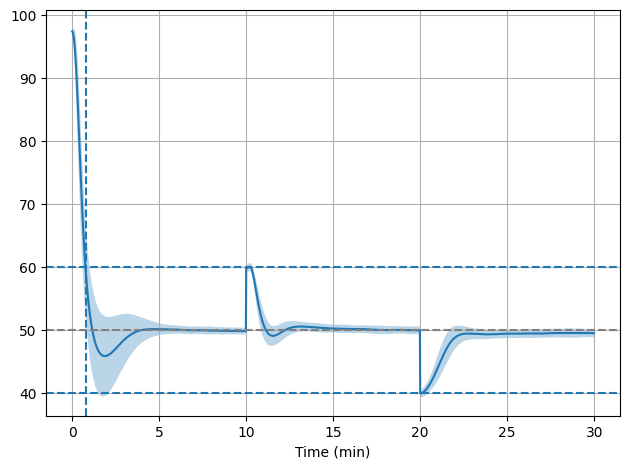

In [68]:
t_sim, ts = 1800, 5
variables = [pid_B_sim(0.05, 440, 19, 0.1244, 284, 10, t_sim, ts, k, model_type='uncertain', noise=True) for k in range(100, 1100)]
nb_patients = 1100 - 100
bis = np.zeros((nb_patients, t_sim))
drug = np.zeros((nb_patients, 2, t_sim))

for i in range(nb_patients):
    bis[i] = variables[i][0]
    drug[i] = variables[i][1]
sleep = np.argmax(bis < 60, axis=1)
bis_B = bis
drug_B = drug

# plotting the BIS
mean = np.mean(bis, axis=0)
std = np.std(bis, axis=0)
plt.figure()
time_in_minutes = np.arange(bis.shape[1]) / 60
plt.plot(time_in_minutes, mean)
plt.fill_between(time_in_minutes, mean - std, mean + std, alpha=0.3)
plt.axhline(y=40, linestyle = '--')
plt.axhline(y=50, linestyle = '--', color='grey')
plt.axhline(y=60, linestyle = '--')
plt.axvline(x=sleep.mean()/60, linestyle='--')
plt.xlabel('Time (min)')
plt.grid(True)
plt.tight_layout()

## induction phase metrics

In [69]:
# time to sleep
tts = (sleep)/60
tts_mean = tts.mean()
tts_std = tts.std()

# low bis time
index = np.zeros((nb_patients, 600))
for i in range(nb_patients):
    for j in range(600):
        if (bis[i, j] < 40):
            index[i, j] = 1
lbt = index.sum(axis=1)
lbt_mean = lbt.mean()
lbt_std = lbt.std()

# lower bis value / bis nadir
BIS_nadir = bis[:, :600].min(axis=1)
BIS_nadir_mean = BIS_nadir.mean()
BIS_nadir_std = BIS_nadir.std()

# settling time 20
st20 = np.zeros(1000)
for i in range(1000):
    for j in range(600-30):
        window = bis[i][j:j+30]
        if np.all((window >= 40)) and np.all((window <= 60)):
            st20[i] = j
            break
st20 = st20/60
st20_mean = st20.mean()
st20_std = st20.std()

# settling time 10
st10 = np.zeros(1000)
for i in range(1000):
    for j in range(600-30):
        window = bis[i][j:j+30]
        if np.all((window >= 45)) and np.all((window <= 55)):
            st10[i] = j
            break
st10 = st10/60
st10_mean = st10.mean()
st10_std = st10.std()

# propo volume
weight = []
weight += [patient_dic[f'patient_{k}'][4][2] for k in range(100, 1100)]
weight = np.array(weight)[:, np.newaxis]
propo = np.divide(drug[:, 0, :600], weight).sum(axis=1)
propo_mean = propo.mean()
propo_std = propo.std()

# remi volume
remi = np.divide(drug[:, 1, :600], weight).sum(axis=1)
remi_mean = remi.mean()
remi_std = remi.std()

In [70]:
print(f'''
      Time to sleep: {tts_mean:.2f} ± {tts_std:.2f} (in minutes)
      Low BIS time: {lbt_mean:.2f} ± {lbt_std:.2f} (in minutes)
      BIS Nadir: {BIS_nadir_mean:.2f} ± {BIS_nadir_std:.2f} (%)
      BIS min: {bis[:, :600].min():.2f}
      Settling Time 20: {st20_mean:.2f} ± {st20_std:.2f} (in minutes)
      Settling Time 10: {st10_mean:.2f} ± {st10_std:.2f} (in minutes)
      Propofol volume: {propo_mean:.2f} ± {propo_std:.2f} (in mg/kg)
      Remifentanil volume: {remi_mean:.2f} ± {remi_std:.2f} (in μg/kg)
''')


      Time to sleep: 0.79 ± 0.16 (in minutes)
      Low BIS time: 15.98 ± 40.86 (in minutes)
      BIS Nadir: 44.89 ± 6.16 (%)
      BIS min: 11.62
      Settling Time 20: 1.00 ± 0.68 (in minutes)
      Settling Time 10: 1.56 ± 0.91 (in minutes)
      Propofol volume: 2.00 ± 0.73 (in mg/kg)
      Remifentanil volume: 4.00 ± 1.47 (in μg/kg)



## maintenance phase metrics

In [71]:
# Integral Absolute Error
IAE = np.sum(np.abs(bis[:, 600:] - 50), axis=1)
IAE_mean = IAE.mean()
IAE_std = IAE.std()

# time out of range 20
index = np.zeros((50, t_sim))
for i in range(50):
    for j in range(600, t_sim):
        if (bis[i, j] < 40) or (bis[i, j] > 60):
            index[i, j] = 1
tor20 = index.sum(axis=1)
tor20_mean = tor20.mean()
tor20_std = tor20.std()

# time out of range 10
for i in range(50):
    for j in range(600, t_sim):
        if (bis[i, j] < 45) or (bis[i, j] > 55):
            index[i, j] = 1
tor10 = index.sum(axis=1)
tor10_mean = tor10.mean()
tor10_std = tor10.std()

# lower BIS value
bis_low = bis[:, 600:].min(axis=1)
bis_low_mean = bis_low.mean()
bis_low_std = bis_low.std()

# higher BIS value
bis_high = bis[:, 600:].max(axis=1)
bis_high_mean = bis_high.mean()
bis_high_std = bis_high.std()

# recovery time
index = np.zeros((nb_patients, 300))
for i in range(nb_patients):
    for j in range(600, 900):
        if (bis[i, j] < 50):
            index[i, j-600] = 1
rt = index.sum(axis=1)
rt_mean = rt.mean()
rt_std = rt.std()

# steady state error
sse = (np.abs(bis[:, -300:] - 50)).mean(axis=1)
sse_mean = sse.mean()
sse_std = sse.std()

# propo volume
weight = []
weight += [patient_dic[f'patient_{k}'][4][2] for k in range(100, 1100)]
weight = np.array(weight)[:, np.newaxis]
propo = np.divide(drug[:, 0, 600:], weight).sum(axis=1)
propo_mean = propo.mean()
propo_std = propo.std()

# remi volume
remi = np.divide(drug[:, 1, 600:], weight).sum(axis=1)
remi_mean = remi.mean()
remi_std = remi.std()

In [72]:
print(f'''
      IAE: {IAE_mean:.2f} +- {IAE_std:.2f} (CV: {IAE_std/IAE_mean:.2f})
      Time out of range 20: {tor20_mean:.2f} +- {tor20_std:.2f} (in seconds)
      Time out of range 10: {tor10_mean:.2f} +- {tor10_std:.2f} (in seconds)
      BIS low: {bis_low_mean:.2f} +- {bis_low_std:.2f}
      BIS high: {bis_high_mean:.2f} +- {bis_high_std:.2f}
      Recovery time: {rt_mean:.2f} +- {rt_std:.2f} (in seconds)
      steady state error: {sse_mean:.2f} +- {sse_std:.2f}
      propo vol: {propo_mean:.2f} +- {propo_std:.2f} (in mg/kg)
      remi vol: {remi_mean:.2f} +- {remi_std:.2f} (in μg/kg)
''')


      IAE: 1859.70 +- 309.12 (CV: 0.17)
      Time out of range 20: 23.66 +- 15.78 (in seconds)
      Time out of range 10: 118.90 +- 30.96 (in seconds)
      BIS low: 39.84 +- 0.66
      BIS high: 60.04 +- 0.61
      Recovery time: 97.20 +- 58.68 (in seconds)
      steady state error: 0.71 +- 0.24
      propo vol: 3.00 +- 1.22 (in mg/kg)
      remi vol: 5.99 +- 2.44 (in μg/kg)



## worst case performance

### induction

In [73]:
# max low bis time
lbt_max = lbt.max()

# minimum bis value recorded
bis_min = bis[:, :600].min()

# cases below bis = 40
index = []
for i in range(1000):
    if len(bis[i, :600][bis[i, :600] < 40]) > 0:
        index.append(1)
und_40 = len(index)

# cases below bis = 45
index = []
for i in range(1000):
    if len(bis[i, :600][bis[i, :600] < 45]) > 0:
        index.append(1)
und_45 = len(index)

In [74]:
print(f'''
      max lbt: {lbt_max:.2f} (in seconds)
      bis min: {bis_min:.2f}
      cases below 40: {und_40} cases
      cases below 45: {und_45} cases 
''')


      max lbt: 293.00 (in seconds)
      bis min: 11.62
      cases below 40: 171 cases
      cases below 45: 340 cases 



### maintenance

In [75]:
# cases below bis = 40
index = []
for i in range(1000):
    if len(bis[i, 600:][bis[i, 600:] < 40]) > 0:
        index.append(1)
und_40 = len(index)

# cases over bis = 60
index = []
for i in range(1000):
    if len(bis[i, 600:][bis[i, 600:] > 60]) > 0:
        index.append(1)
ovr_60 = len(index)

In [76]:
print(f'''
      cases below 40: {und_40} cases
      cases over 60: {ovr_60} cases 
''')


      cases below 40: 580 cases
      cases over 60: 508 cases 



# Input/Output Plot

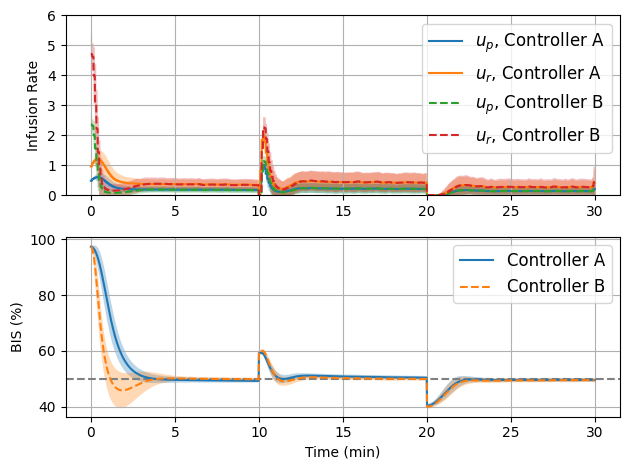

In [77]:
time_in_minutes = np.arange(bis.shape[1]) / 60
mean_A, std_A = bis_A.mean(axis=0), bis_A.std(axis=0)
mean_B, std_B = bis_B.mean(axis=0), bis_B.std(axis=0)
propo_A, remi_A = drug_A[:, 0, :], drug_A[:, 1, :]
mean_propo_A, std_propo_A = propo_A.mean(axis=0), propo_A.std(axis=0)
mean_remi_A, std_remi_A = remi_A.mean(axis=0), remi_A.std(axis=0)
propo_B, remi_B = drug_B[:, 0, :], drug_B[:, 1, :]
mean_propo_B, std_propo_B = propo_B.mean(axis=0), propo_B.std(axis=0)
mean_remi_B, std_remi_B = remi_B.mean(axis=0), remi_B.std(axis=0)

plt.subplot(2, 1, 1)
plt.ylim(0, 6)
plt.plot(time_in_minutes, mean_propo_A, label='$u_p$, Controller A')
plt.fill_between(time_in_minutes, mean_propo_A - std_propo_A, mean_propo_A + std_propo_A, alpha=0.3)
plt.plot(time_in_minutes, mean_remi_A, label='$u_r$, Controller A')
plt.fill_between(time_in_minutes, mean_remi_A - std_remi_A, mean_remi_A + std_remi_A, alpha=0.3)
plt.plot(time_in_minutes, mean_propo_B, '--', label='$u_p$, Controller B')
plt.fill_between(time_in_minutes, mean_propo_B - std_propo_B, mean_propo_B + std_propo_B, alpha=0.3)
plt.plot(time_in_minutes, mean_remi_B, '--', label='$u_r$, Controller B')
plt.fill_between(time_in_minutes, mean_remi_B - std_remi_B, mean_remi_B + std_remi_B, alpha=0.3)
plt.grid(True)
plt.legend(fontsize='large')
plt.ylabel('Infusion Rate')
plt.subplot(2, 1, 2)
plt.axhline(y=50, linestyle='--', color='grey')
plt.plot(time_in_minutes, mean_A, label='Controller A')
plt.fill_between(time_in_minutes, mean_A - std_A, mean_A + std_A, alpha=0.3)
plt.plot(time_in_minutes, mean_B, linestyle='--', label='Controller B')
plt.fill_between(time_in_minutes, mean_B - std_B, mean_B + std_B, alpha=0.3)
plt.grid(True)
plt.legend(fontsize='large')
plt.xlabel('Time (min)')
plt.ylabel('BIS (%)')
plt.tight_layout()
# plt.savefig('output.pdf', bbox_inches='tight')